# Lab assigment 5
## Bloom filters

### Pedro Otero García & Alexandre Sousa Cajide

### Step 1
#### Set-up the bloom filter

In [1]:
import mmh3

class BloomFilter:
  def __init__(self, m, k, q):
      self.m = m  # Size of the filter
      self.k = k  # Number of hash functions
      self.q = q  # q-grams

      # Create a bit array of size m, initialized with zeros
      # This are going to be the bloom filter
      self.filter = [0] * m

  def add(self, name: str):
    if len(name) < self.q:
      self._addQgram(name)
    else:
      for i in range(len(name) - self.q + 1):
        self._addQgram(name[i:i+self.q])

  def _addQgram(self, qgram):
    # Double hash q-gram and set corresponding bits to 1
    for i in range(1, self.k + 1):
        hash1 = mmh3.hash(qgram)
        hash2 = mmh3.hash(qgram, 1)
        index = (hash1 + i * hash2) % self.m
        self.filter[index] = 1

  def check(self, name: str):
      if len(name) < self.q:
        if not self._checkQgram(name):
            return False
      else:
        for i in range(len(name) - self.q + 1):
          if not self._checkQgram(name[i:i+self.q]):
            return False
      return True

  def _checkQgram(self, qgram):
      # Check if all bits are set to 1 for the given q-gram
      for i in range(1, self.k + 1):
          hash1 = mmh3.hash(qgram)
          hash2 = mmh3.hash(qgram, 1)
          index = (hash1 + i * hash2) % self.m
          if self.filter[index] == 0:
              return False
      return True


# Define parameters
m = 10000  # Size of the filter
k = 5     # Number of hash functions
q = 2     # Number of q-grams

# Create and initialize the Bloom Filter
bloom_filter = BloomFilter(m, k, q)
bloom_filter.add("Alex")
bloom_filter.add("Pedro")

# Check if a q-gram is in the filter
print("Alex:",bloom_filter.check("Alex"))
print("Anthea:",bloom_filter.check("Anthea"))

Alex: True
Anthea: False


### Step 2

#### Reading datasets.

In [2]:
import pandas as pd
import numpy as np

# - Dataset example names
en = pd.read_csv('pprl-attack-data/example-names.csv')
print(en.head(5))

# - German names
gn = pd.read_csv('pprl-attack-data/german-names.csv')
print(gn.head(5))

     name  frequency
0  Daniel        242
1  Carlos        130
2  Danilo        115
3   Carla         48
4   David         95
       name  frequency
0     Peter    1293922
1   Michael    1088118
2  Wolfgang    1075005
3    Thomas    1011277
4     Klaus     992990


#### Generate a realistic data.

In [3]:
import random

def genDataFrame(df, s):
  # - Generate data frame of length l using the names
  #   in df with its corresponding f.

  samples = []

  for _, row in df.iterrows():
      name = row['name']
      f = row['frequency']

      samples.extend([name] * f)

  data = np.random.choice(samples, size=s, replace=True)

  df_generated = pd.DataFrame({'name': data})

  return df_generated

def selectNnames(df,n):
  # - n random rows of a dataframe.
  sampled_df = df.sample(n=n, random_state=random.seed())

  return sampled_df


df = selectNnames(gn,n=5)
print(list(df['name'].unique()))
df = genDataFrame(df,1000)
print(list(df['name'].unique()))

['Gunther', 'Auguste', 'Ingo', 'William', 'Ivonne']
['Ingo', 'Gunther', 'Auguste', 'Ivonne', 'William']


#### Generate a realistic scenario with optimal parameters.

In [4]:
import math

def genScenario(n: int, m: int, k: int, q: int, s: int) -> [pd.DataFrame, pd.DataFrame, pd.DataFrame]:
        '''
            Generate a real scenario.
            @params:
                n: Number of different names in the synthetic dataset.
                m: Length of bloom filters. 
                k: Number of hash functions.
                s: Length of the synthetic dataset

            @returns:
                df: Synthetic dataset of names.
                bfs: Bloom filters dataset for each row in df.
                real_df: Dataset with the names in df and its corresponding bloom filter.
        '''
    
        df = selectNnames(gn,n)
        df = genDataFrame(df,s)

        filters = []
        freqs = []
        for name in df['name'].unique():
                bf = BloomFilter(m, k, q)
                bf.add(name)
                filters.append(bf.filter)
                freqs.append(df['name'].value_counts()[name])
        bfs = pd.DataFrame({'filter': filters, 'frequency': freqs})
        bfs = bfs.sample(frac=1).reset_index(drop=True)
        bfs = bfs.sort_values(by='frequency', ascending=False)

        # 'real_df' are going to be used to check the result
        # of the attack.
        real_df = pd.DataFrame()
        real_df['name'] = df['name'].unique()
        real_df['filter'] = filters
        real_df['frequency'] = freqs
        real_df = real_df.sample(frac=1).reset_index(drop=True)
        real_df = real_df.sort_values(by='frequency', ascending=False)

        return df, bfs, real_df



# - Parameters selected by the user.
n = 500
q = 2
# - Optimal parameters.
epsilon = 5e-8
m = round(-n*math.log(epsilon)/(math.log(2) ** 2))
k = round(m/n*math.log(2))

print("Optimal parameters:")
print('\tEpsilon =',epsilon)
print('\tn =',n)
print('\tm =',m)
print('\tk =',k)
print()

df, bfs, real_df = genScenario(n=n,m=m,k=k,q=q,s=10000)
print("Generated dataset:")
print(df.head())
print()
print("Dataset for analysis in step 4:")
print(real_df.head())

Optimal parameters:
	Epsilon = 5e-08
	n = 500
	m = 17495
	k = 24

Generated dataset:
     name
0  Viktor
1   Karin
2  Monika
3   Franz
4  Werner

Dataset for analysis in step 4:
        name                                             filter  frequency
222  Michael  [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...        247
144   Ursula  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...        234
66    Werner  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...        213
139  Andreas  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...        210
320   Monika  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...        195


In [5]:
real_df

,name,filter,frequency
222,Michael,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",247
144,Ursula,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",234
66,Werner,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",213
139,Andreas,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",210
320,Monika,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",195
...,...,...,...
19,Hans-Christian,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...",1
32,Hellmut,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1
422,Fatma,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1
429,Hans-Otto,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1


### Step 3

#### Code of the attacker

In [6]:
def computeQgrams(name: str, q: int) -> list:
    q_grams = []
    if len(name) < q:
        q_grams.append(name)
    else:
        for i in range(len(name) - q + 1):
            q_grams.append(name[i:i+q])

    return q_grams

def getPos1(filter: list) -> list:
    pos1 = []
    for pos,i in enumerate(filter):
        if i == 1:
            pos1.append(pos)
    return pos1


def attack(q: int, t: int, df: pd.DataFrame, bfs: pd.DataFrame) -> [list,list,list]:
    '''
        Re-identification attack.
        @params:
            q: number of q-grams.
            t: frequency threshold.
            df: df to perform the re-identification.
            bfs: dataset of the bloom filters.

        @returns:
            cand_qgs: Candidates q-grams per position of bloom filter.
            cand_nms: Candidates names per bloom filter.
            list[bfs['filter']]: Bloom filters.
    '''

    print("Bloom filters:")
    bfs = bfs[bfs['frequency'] >= t]
    bfs = bfs.sort_values(by='frequency', ascending=False)
    print(bfs.head(5))
    print("Length:",len(bfs))
    print()

    print("Dataframe for the attack:")
    df4attack = df['name'].value_counts().reset_index()
    df4attack.columns = ['name', 'frequency']
    df4attack = df4attack[df4attack['frequency'] >= t]
    
    qgrams = []
    for name in df4attack['name']:
        qgrams.append(computeQgrams(name, q))

    df4attack['q-grams'] = qgrams
    df4attack = df4attack.sort_values(by='frequency', ascending=False)
    print(df4attack.head(5))
    print("Length:",len(df4attack))

    # Candidates q-grams
    cand_qgs = []

    # Computing candidates for each position in filter's length
    for i in range(0,len(bfs['filter'].iloc[0])):
        pos_cands = [] # Possitive candidates set.
        neg_cands = [] # Negative candidates set.
        for j, flt in enumerate(bfs['filter']):
            qgs = df4attack['q-grams'].iloc[j]
            if flt[i] == 1:
                pos_cands = list(set(pos_cands + qgs))
            else:
                neg_cands = list(set(neg_cands + qgs))
        cand_qgs.append(list(set(pos_cands)-set(neg_cands)))
        
    # Re-identification
    cand_nms = []
    for flt in bfs['filter']:
        cn = list(df4attack['name'])
        # Checking each position where filter is equal to '1'.
        for pos in getPos1(flt):
            for _, row in df4attack[['name', 'q-grams']].iterrows():
                # Checking if there ARE NOT candidates for a name
                # in position 'pos'.
                if not any(qg in cand_qgs[pos] for qg in row['q-grams']):
                    try:
                        cn.remove(row['name'])
                    except:
                        continue
        cand_nms.append(cn)

        
    return cand_qgs, cand_nms, list(bfs['filter'])

### Step 4

#### Performing the attack.

In [7]:
cand_qgs, cand_nms, filters = attack(q=2, t=15, df=df, bfs=bfs)

Bloom filters:
                                                filter  frequency
81   [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...        247
101  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...        234
107  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...        213
179  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...        210
243  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...        195
Length: 145

Dataframe for the attack:
      name  frequency                   q-grams
0  Michael        247  [Mi, ic, ch, ha, ae, el]
1   Ursula        234      [Ur, rs, su, ul, la]
2   Werner        213      [We, er, rn, ne, er]
3  Andreas        210  [An, nd, dr, re, ea, as]
4   Monika        195      [Mo, on, ni, ik, ka]
Length: 145


#### Analyzing results:

In [8]:
def analysis(real_df, cand_nms, filters):
    print("\nTotal Bloom filters to identify:", len(filters))

    exact_mts = 0   # Counter for exact matches.
    false_mts = 0   # Counter for false matches.
    potential_mts = 0   # Counter for potential matches.
    no_mts = 0  # Counter for no matches at all.

    for i,fi in enumerate(real_df['filter']):
        for j,fj in enumerate(filters):
            if fi == fj:
                if real_df['name'].iloc[i] in cand_nms[j]:
                    if len(cand_nms[j]) == 1:
                        exact_mts +=1
                    else:
                        potential_mts += 1
                else:
                    if len(cand_nms[j]) == 1:
                        false_mts += 1
                    else:
                        no_mts += 1
                

    print("Exact matches: %i (%2.2f %%)" % (exact_mts, exact_mts/len(cand_nms)*100))
    print("Potential matches: %i (%2.2f %%)" % (potential_mts, potential_mts/len(cand_nms)*100))
    print("False matches: %i (%2.2f %%)" % (false_mts, false_mts/len(cand_nms)*100))
    print("No matches: %i (%2.2f %%)" % (no_mts, no_mts/len(cand_nms)*100))

    return exact_mts, potential_mts, false_mts, no_mts

analysis(real_df=real_df, cand_nms=cand_nms, filters=filters) 


Total Bloom filters to identify: 145
Exact matches: 34 (23.45 %)
Potential matches: 0 (0.00 %)
False matches: 51 (35.17 %)
No matches: 60 (41.38 %)


(34, 0, 51, 60)

### Step 5

In this step, it is going to be check the performance when some parameters are changed.
In particular, 7 different values for the following features:
* **q**: q-grams.
* **t**: The threshold use in the attack to filter the BF with less frequency.
* **m**: Length of the bloom filter.
* **n**: The number of different names in the data.
* **k**: The number of hash functions.

In [9]:
# 'time' library is used to check how many time it takes to perform 
# generation and attack process the whole process.
import time 

# - Parameters selected by the user.
n = 550
s = 100000
t = 60
# - Optimal parameters.
epsilon = 5e-8
m = round(-n*math.log(epsilon)/(math.log(2) ** 2))
k = round(m/n*math.log(2))

mul = np.arange(0.25, 1.76, 0.25)
v_q = np.arange(1, 8, 1)
v_t = [round(e) for e in t*mul]
v_m = []
v_k = []
v_n = []

for i in mul:
    v_m.append(round(i*m))
    v_k.append(round(i*k))
    v_n.append(round(i*n)) 

In [10]:
# Graph settings

import matplotlib.pyplot as plt 

# set width of bar 
barWidth = 0.2

# Set position of bar on X axis 
br1 = np.arange(len(mul)) 
br2 = [x + barWidth for x in br1] 
br3 = [x + barWidth for x in br2] 
br4 = [x + barWidth for x in br3] 

* TEST: Change q-grams (q).



	[1-GRAM] - GENERATING SCENARIO ...

	[1-GRAM] - PERFORMING ATTACK...

Bloom filters:
                                                filter  frequency
470  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...       2334
505  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...       1963
412  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...       1874
513  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...       1741
428  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...       1675
Length: 217

Dataframe for the attack:
       name  frequency                   q-grams
0     Peter       2334           [P, e, t, e, r]
1  Wolfgang       1963  [W, o, l, f, g, a, n, g]
2   Michael       1874     [M, i, c, h, a, e, l]
3     Klaus       1741           [K, l, a, u, s]
4    Werner       1675        [W, e, r, n, e, r]
Length: 217


	[1-GRAM] - ANALYZING RESULTS...


Total Bloom filters to identify: 217
Exact matches: 1 (0.46 %)
Potential matches: 0 (0.00 %)
False matches: 0 (0.00 %)
No matches: 244

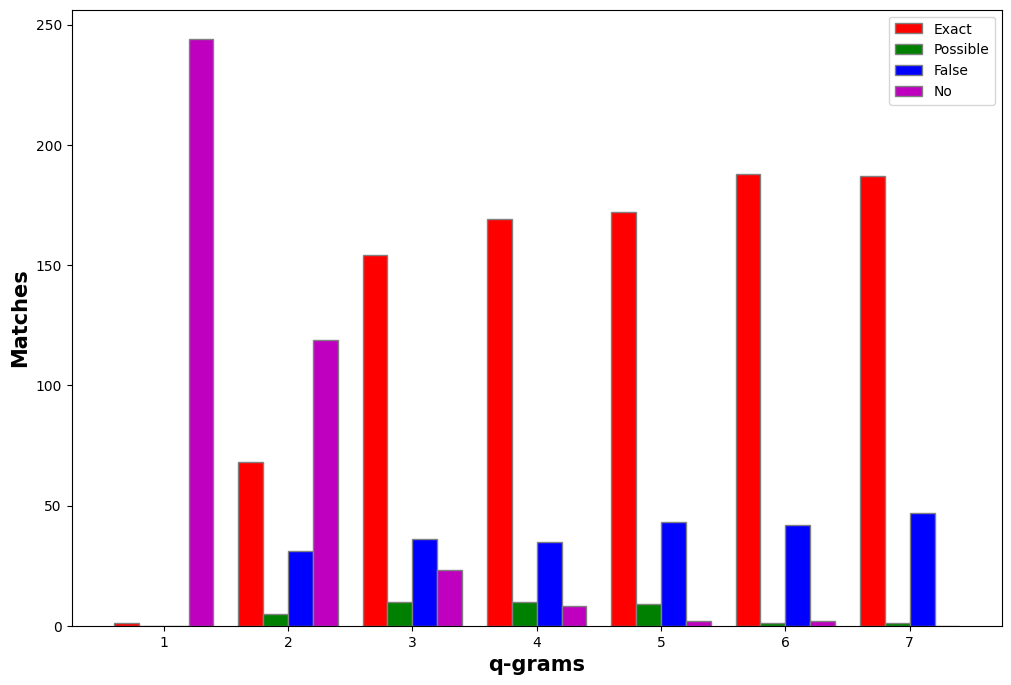



	RUNNING TIMES:
-> [1-gram]: 226.04226112365723
-> [2-gram]: 227.77139472961426
-> [3-gram]: 210.85012125968933
-> [4-gram]: 185.5980269908905
-> [5-gram]: 159.92369747161865
-> [6-gram]: 130.86117482185364
-> [7-gram]: 104.27040410041809


In [13]:
ex_mts = [] # Exact matches.
ps_mts = [] # Possible matches.
fs_mts = [] # False matches.
no_mts = [] # No matches at all.
times = []
for q_i in v_q:
    start_time = time.time()
    print(f"\n\n\t[{q_i}-GRAM] - GENERATING SCENARIO ...\n")
    df, bfs, real_df = genScenario(n=n,m=m,k=k,q=q_i,s=s)
    print(f"\t[{q_i}-GRAM] - PERFORMING ATTACK...\n")
    cand_qgs, cand_nms, filters = attack(q=q_i, t=t, df=df, bfs=bfs)
    print(f"\n\n\t[{q_i}-GRAM] - ANALYZING RESULTS...\n")
    ex, ps, fs, no = analysis(real_df=real_df, filters=filters, cand_nms=cand_nms)    
    ex_mts.append(ex)
    ps_mts.append(ps)
    fs_mts.append(fs)
    no_mts.append(no)
    end_time = time.time()
    times.append(end_time-start_time)

fig = plt.subplots(figsize =(12, 8)) 

plt.bar(br1, ex_mts, color ='r', width = barWidth, 
        edgecolor ='grey', label ='Exact') 
plt.bar(br2, ps_mts, color ='g', width = barWidth, 
        edgecolor ='grey', label ='Possible') 
plt.bar(br3, fs_mts, color ='b', width = barWidth, 
        edgecolor ='grey', label ='False') 
plt.bar(br4, no_mts, color ='m', width = barWidth, 
        edgecolor ='grey', label ='No')
 
plt.xlabel('q-grams', fontweight ='bold', fontsize = 15) 
plt.ylabel('Matches', fontweight ='bold', fontsize = 15) 
plt.xticks([r + 1.5*barWidth for r in range(len(mul))], v_q)

plt.legend()
plt.show() 

print("\n\n\tRUNNING TIMES:")
for i, q_i in enumerate(v_q):
    print(f"-> [{q_i}-gram]: {times[i]}")

* TEST: Change threshold (t).



	[THRESHOLD: 15] - GENERATING SCENARIO ...

	[THRESHOLD: 15] - - PERFORMING ATTACK...

Bloom filters:
                                                filter  frequency
124  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...       2337
228  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...       1950
75   [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...       1779
226  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...       1687
529  [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...       1622
Length: 432

Dataframe for the attack:
      name  frequency                   q-grams
0    Peter       2337          [Pe, et, te, er]
1    Klaus       1950          [Kl, la, au, us]
2  Manfred       1779  [Ma, an, nf, fr, re, ed]
3    Maria       1687          [Ma, ar, ri, ia]
4     Hans       1622              [Ha, an, ns]
Length: 432


	[THRESHOLD: 15] - - ANALYZING RESULTS...


Total Bloom filters to identify: 432
Exact matches: 48 (11.11 %)
Potential matches: 3 (0.69 %)
False matches: 60 (1

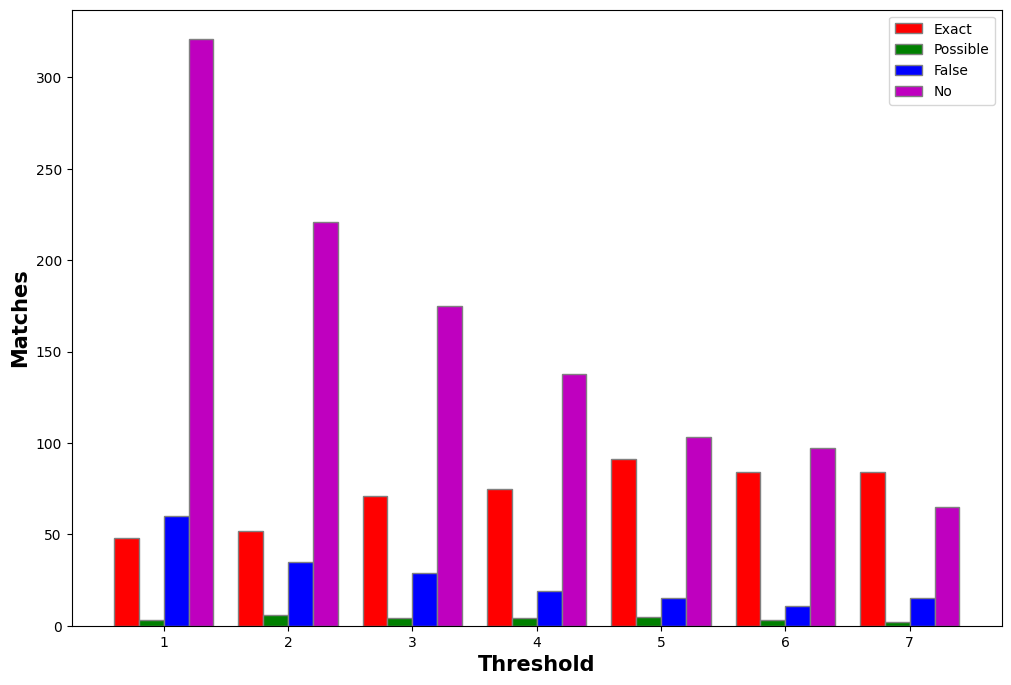



	RUNNING TIMES:
-> [THRESHOLD: 15]: 770.375851392746
-> [THRESHOLD: 30]: 446.49125027656555
-> [THRESHOLD: 45]: 363.1072566509247
-> [THRESHOLD: 60]: 280.30695128440857
-> [THRESHOLD: 75]: 217.3671169281006
-> [THRESHOLD: 90]: 183.2891595363617
-> [THRESHOLD: 105]: 137.44305729866028


In [202]:
ex_mts = [] # Exact matches.
ps_mts = [] # Possible matches.
fs_mts = [] # False matches.
no_mts = [] # No matches at all.
times = []
for t_i in v_t:
    start_time = time.time()
    print(f"\n\n\t[THRESHOLD: {t_i}] - GENERATING SCENARIO ...\n")
    df, bfs, real_df = genScenario(n=n,m=m,k=k,q=q,s=s)
    print(f"\t[THRESHOLD: {t_i}] - - PERFORMING ATTACK...\n")
    cand_qgs, cand_nms, filters = attack(q=q, t=t_i, df=df, bfs=bfs)
    print(f"\n\n\t[THRESHOLD: {t_i}] - - ANALYZING RESULTS...\n")
    ex, ps, fs, no = analysis(real_df=real_df, filters=filters, cand_nms=cand_nms)    
    ex_mts.append(ex)
    ps_mts.append(ps)
    fs_mts.append(fs)
    no_mts.append(no)
    end_time = time.time()
    times.append(end_time-start_time)

fig = plt.subplots(figsize =(12, 8)) 

plt.bar(br1, ex_mts, color ='r', width = barWidth, 
        edgecolor ='grey', label ='Exact') 
plt.bar(br2, ps_mts, color ='g', width = barWidth, 
        edgecolor ='grey', label ='Possible') 
plt.bar(br3, fs_mts, color ='b', width = barWidth, 
        edgecolor ='grey', label ='False') 
plt.bar(br4, no_mts, color ='m', width = barWidth, 
        edgecolor ='grey', label ='No')
 
plt.xlabel('Threshold', fontweight ='bold', fontsize = 15) 
plt.ylabel('Matches', fontweight ='bold', fontsize = 15) 
plt.xticks([r + 1.5*barWidth for r in range(len(mul))], v_q)

plt.legend()
plt.show() 

print("\n\n\tRUNNING TIMES:")
for i, t_i in enumerate(v_t):
    print(f"-> [THRESHOLD: {t_i}]: {times[i]}")

* TEST: Change length of bloom filter (m). 



	[LENGTH (m): 4811] - GENERATING SCENARIO ...

	[LENGTH (m): 4811] - - PERFORMING ATTACK...

Bloom filters:
                                                filter  frequency
256  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...       2185
174  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...       2146
474  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...       2013
475  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...       1792
309  [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...       1732
Length: 221

Dataframe for the attack:
       name  frequency                       q-grams
0   Michael       2185      [Mi, ic, ch, ha, ae, el]
1  Wolfgang       2146  [Wo, ol, lf, fg, ga, an, ng]
2    Thomas       2013          [Th, ho, om, ma, as]
3   Manfred       1792      [Ma, an, nf, fr, re, ed]
4   Andreas       1732      [An, nd, dr, re, ea, as]
Length: 221


	[LENGTH (m): 4811] - - ANALYZING RESULTS...


Total Bloom filters to identify: 221
Exact matches: 71 (32.13 %)
Potential m

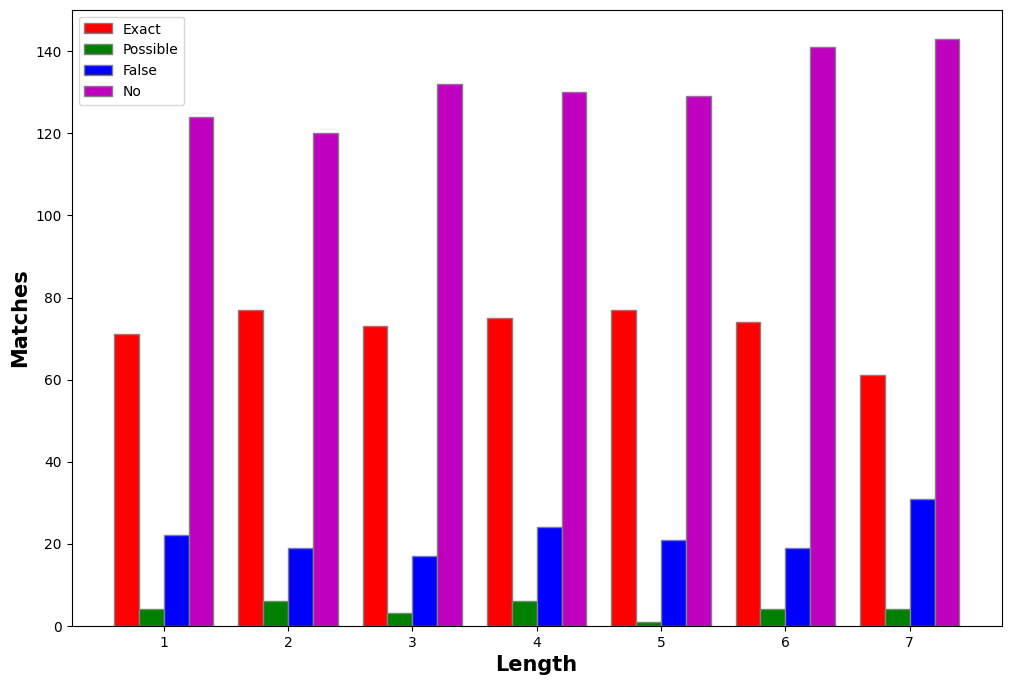



	RUNNING TIMES:
-> [LENGTH (m): 4811]: 204.7370207309723
-> [LENGTH (m): 9622]: 204.38442206382751
-> [LENGTH (m): 14434]: 219.415776014328
-> [LENGTH (m): 19245]: 267.0904817581177
-> [LENGTH (m): 24056]: 260.8167304992676
-> [LENGTH (m): 28868]: 309.89851093292236
-> [LENGTH (m): 33679]: 359.5547409057617


In [204]:
ex_mts = [] # Exact matches.
ps_mts = [] # Possible matches.
fs_mts = [] # False matches.
no_mts = [] # No matches at all.
times = []
for m_i in v_m:
    start_time = time.time()
    print(f"\n\n\t[LENGTH (m): {m_i}] - GENERATING SCENARIO ...\n")
    df, bfs, real_df = genScenario(n=n,m=m_i,k=k,q=q,s=s)
    print(f"\t[LENGTH (m): {m_i}] - - PERFORMING ATTACK...\n")
    cand_qgs, cand_nms, filters = attack(q=q, t=t, df=df, bfs=bfs)
    print(f"\n\n\t[LENGTH (m): {m_i}] - - ANALYZING RESULTS...\n")
    ex, ps, fs, no = analysis(real_df=real_df, filters=filters, cand_nms=cand_nms)    
    ex_mts.append(ex)
    ps_mts.append(ps)
    fs_mts.append(fs)
    no_mts.append(no)
    end_time = time.time()
    times.append(end_time-start_time)

fig = plt.subplots(figsize =(12, 8)) 

plt.bar(br1, ex_mts, color ='r', width = barWidth, 
        edgecolor ='grey', label ='Exact') 
plt.bar(br2, ps_mts, color ='g', width = barWidth, 
        edgecolor ='grey', label ='Possible') 
plt.bar(br3, fs_mts, color ='b', width = barWidth, 
        edgecolor ='grey', label ='False') 
plt.bar(br4, no_mts, color ='m', width = barWidth, 
        edgecolor ='grey', label ='No')
 
plt.xlabel('Length', fontweight ='bold', fontsize = 15) 
plt.ylabel('Matches', fontweight ='bold', fontsize = 15) 
plt.xticks([r + 1.5*barWidth for r in range(len(mul))], v_q)

plt.legend()
plt.show() 

print("\n\n\tRUNNING TIMES:")
for i, m_i in enumerate(v_m):
    print(f"-> [LENGTH (m): {m_i}]: {times[i]}")

* TEST: Change the number of different names (n):



	[NAMES (n): 138] - GENERATING SCENARIO ...

	[NAMES (n): 138] - - PERFORMING ATTACK...

Bloom filters:
                                                filter  frequency
1    [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...       7270
45   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...       5998
71   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...       5791
86   [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...       4871
111  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...       4569
Length: 100

Dataframe for the attack:
      name  frequency                   q-grams
0  Manfred       7270  [Ma, an, nf, fr, re, ed]
1   Günter       5998      [Gü, ün, nt, te, er]
2   Renate       5791      [Re, en, na, at, te]
3    Frank       4871          [Fr, ra, an, nk]
4    Bernd       4569          [Be, er, rn, nd]
Length: 100


	[NAMES (n): 138] - - ANALYZING RESULTS...


Total Bloom filters to identify: 100
Exact matches: 81 (81.00 %)
Potential matches: 1 (1.00 %)
False matches: 5 

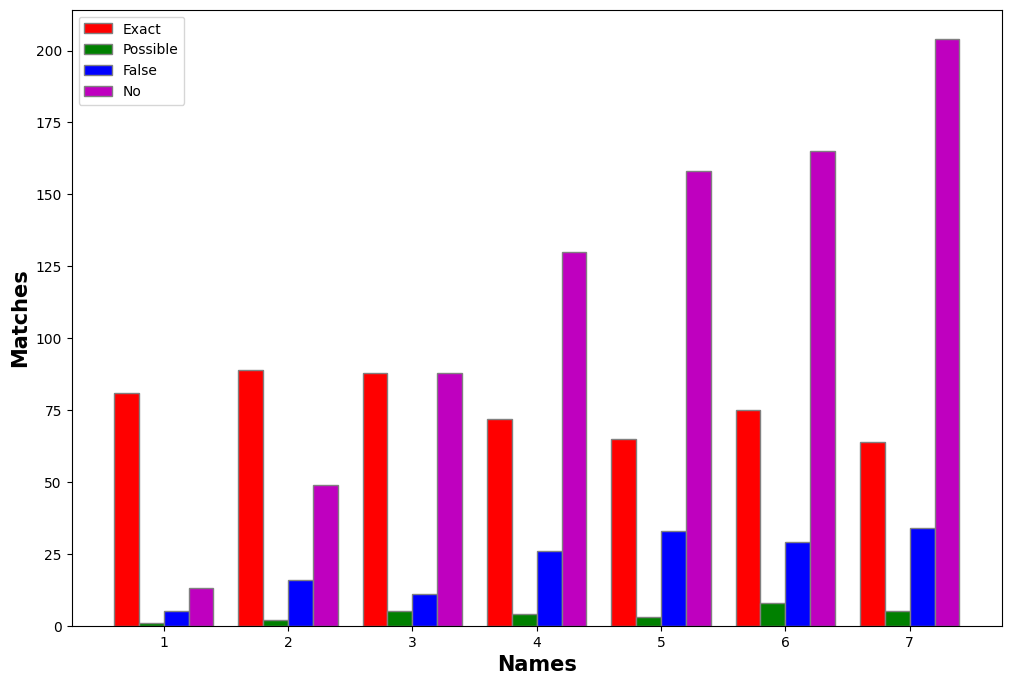



	RUNNING TIMES:
-> [NAMES (n): 138]: 52.91948914527893
-> [NAMES (n): 275]: 115.24119472503662
-> [NAMES (n): 412]: 176.2303524017334
-> [NAMES (n): 550]: 240.91108322143555
-> [NAMES (n): 688]: 309.81890869140625
-> [NAMES (n): 825]: 329.2868981361389
-> [NAMES (n): 962]: 408.90714383125305


In [11]:
ex_mts = [] # Exact matches.
ps_mts = [] # Possible matches.
fs_mts = [] # False matches.
no_mts = [] # No matches at all.
times = []
for n_i in v_n:
    start_time = time.time()
    print(f"\n\n\t[NAMES (n): {n_i}] - GENERATING SCENARIO ...\n")
    df, bfs, real_df = genScenario(n=n_i,m=m,k=k,q=q,s=s)
    print(f"\t[NAMES (n): {n_i}] - - PERFORMING ATTACK...\n")
    cand_qgs, cand_nms, filters = attack(q=q, t=t, df=df, bfs=bfs)
    print(f"\n\n\t[NAMES (n): {n_i}] - - ANALYZING RESULTS...\n")
    ex, ps, fs, no = analysis(real_df=real_df, filters=filters, cand_nms=cand_nms)    
    ex_mts.append(ex)
    ps_mts.append(ps)
    fs_mts.append(fs)
    no_mts.append(no)
    end_time = time.time()
    times.append(end_time-start_time)

fig = plt.subplots(figsize =(12, 8)) 

plt.bar(br1, ex_mts, color ='r', width = barWidth, 
        edgecolor ='grey', label ='Exact') 
plt.bar(br2, ps_mts, color ='g', width = barWidth, 
        edgecolor ='grey', label ='Possible') 
plt.bar(br3, fs_mts, color ='b', width = barWidth, 
        edgecolor ='grey', label ='False') 
plt.bar(br4, no_mts, color ='m', width = barWidth, 
        edgecolor ='grey', label ='No')
 
plt.xlabel('Names', fontweight ='bold', fontsize = 15) 
plt.ylabel('Matches', fontweight ='bold', fontsize = 15) 
plt.xticks([r + 1.5*barWidth for r in range(len(mul))], v_q)

plt.legend()
plt.show() 

print("\n\n\tRUNNING TIMES:")
for i, n_i in enumerate(v_n):
    print(f"-> [NAMES (n): {n_i}]: {times[i]}")

* TEST: Changing the number of hash functions (k).



	[HASH (k): 6] - GENERATING SCENARIO ...



	[HASH (k): 6] - - PERFORMING ATTACK...

Bloom filters:
                                                filter  frequency
146  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...       2161
291  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...       2060
270  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...       1977
106  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...       1920
253  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...       1816
Length: 233

Dataframe for the attack:
       name  frequency                       q-grams
0  Wolfgang       2161  [Wo, ol, lf, fg, ga, an, ng]
1    Thomas       2060          [Th, ho, om, ma, as]
2    Werner       1977          [We, er, rn, ne, er]
3   Manfred       1920      [Ma, an, nf, fr, re, ed]
4    Ursula       1816          [Ur, rs, su, ul, la]
Length: 233


	[HASH (k): 6] - - ANALYZING RESULTS...


Total Bloom filters to identify: 233
Exact matches: 78 (33.48 %)
Potential matches: 3 (1.29 %)
False matches: 24 (10.30 %)
No matches: 

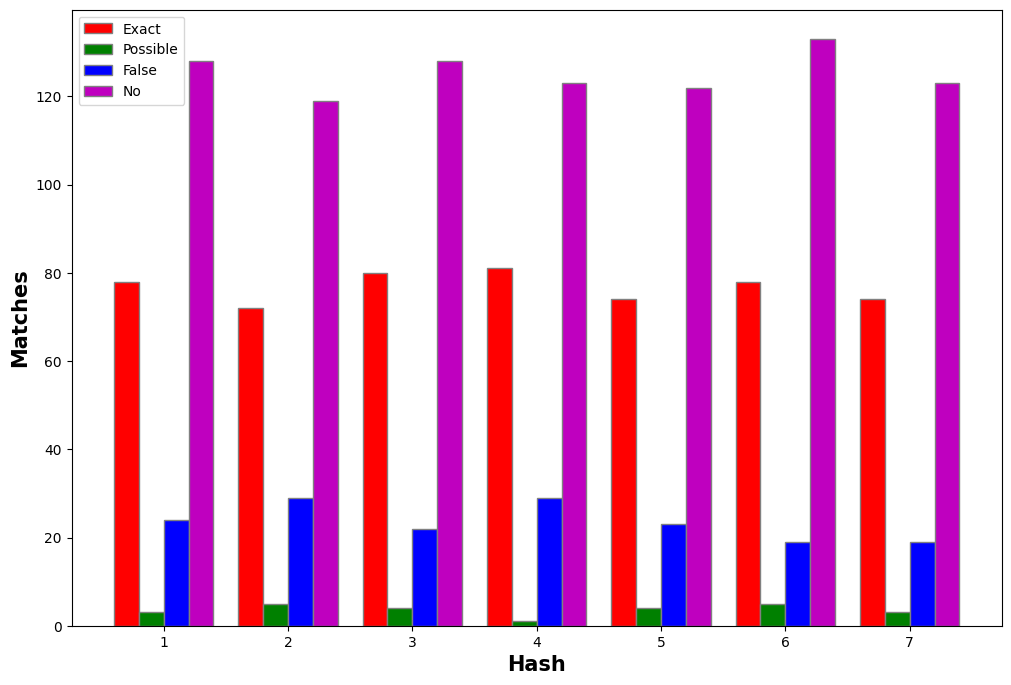



	RUNNING TIMES:
-> [HASH (k): 6]: 97.93705725669861
-> [HASH (k): 12]: 143.53770089149475
-> [HASH (k): 18]: 195.76827239990234
-> [HASH (k): 24]: 246.14041781425476
-> [HASH (k): 30]: 270.76312923431396
-> [HASH (k): 36]: 347.502694606781
-> [HASH (k): 42]: 354.17284893989563


In [12]:
ex_mts = [] # Exact matches.
ps_mts = [] # Possible matches.
fs_mts = [] # False matches.
no_mts = [] # No matches at all.
times = []
for k_i in v_k:
    start_time = time.time()
    print(f"\n\n\t[HASH (k): {k_i}] - GENERATING SCENARIO ...\n")
    df, bfs, real_df = genScenario(n=n,m=m,k=k_i,q=q,s=s)
    print(f"\t[HASH (k): {k_i}] - - PERFORMING ATTACK...\n")
    cand_qgs, cand_nms, filters = attack(q=q, t=t, df=df, bfs=bfs)
    print(f"\n\n\t[HASH (k): {k_i}] - - ANALYZING RESULTS...\n")
    ex, ps, fs, no = analysis(real_df=real_df, filters=filters, cand_nms=cand_nms)    
    ex_mts.append(ex)
    ps_mts.append(ps)
    fs_mts.append(fs)
    no_mts.append(no)
    end_time = time.time()
    times.append(end_time-start_time)

fig = plt.subplots(figsize =(12, 8)) 

plt.bar(br1, ex_mts, color ='r', width = barWidth, 
        edgecolor ='grey', label ='Exact') 
plt.bar(br2, ps_mts, color ='g', width = barWidth, 
        edgecolor ='grey', label ='Possible') 
plt.bar(br3, fs_mts, color ='b', width = barWidth, 
        edgecolor ='grey', label ='False') 
plt.bar(br4, no_mts, color ='m', width = barWidth, 
        edgecolor ='grey', label ='No')
 
plt.xlabel('Hash', fontweight ='bold', fontsize = 15) 
plt.ylabel('Matches', fontweight ='bold', fontsize = 15) 
plt.xticks([r + 1.5*barWidth for r in range(len(mul))], v_q)

plt.legend()
plt.show() 

print("\n\n\tRUNNING TIMES:")
for i, k_i in enumerate(v_k):
    print(f"-> [HASH (k): {k_i}]: {times[i]}")

**Considerations:**

* The large number of no matches are due to the frequency-by-frequency filter.
* The most influential parameter in finding matches is the q-gram since it has to be exactly the same name in the filter avoiding collision with other hashes.
* Increasing the threshold helps to obtain more accurate hits by decreasing false positives and partial hits.
* The length of the bloom filter does not seem to have a large variance in the final result for the values used. * Using a very small length would increase collisions and using a very large length would increase the computation time. The same for the number of hash functions.
* As fewer names used, lower the collisions and  higher the exact number of exact matches.